# Monthly Industry Time Series Meta Data Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as w
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ks_2samp

In [2]:
np.random.seed(1999)
w.simplefilter("ignore")

## Builds Meta Target

We define $$OWA_0 := mean\{OWA_{trotta}, OWA_{alves}, OWA_{muk}, OWA_{rnn}, OWA_{pelka}, OWA_{mlp}\}$$ and $$OWA_1 := mean\{OWA_{theta}, OWA_{arima}, OWA_{damped}, OWA_{ets}, OWA_{holt}, OWA_{ses}\}$$ as the group 0 and group 1 errors, respectively. The meta target is given by: $$Y=\mathbb{I}\{OWA_0 < OWA_1\}$$

In [3]:
trotta = pd.read_csv("../Metrics/trotta.csv", index_col=0)
alves = pd.read_csv("../Metrics/alves.csv", index_col=0)
muk = pd.read_csv("../Metrics/muk.csv", index_col=0)
rnn = pd.read_csv("../Metrics/rnn.csv", index_col=0)
pelka = pd.read_csv("../Metrics/pelka.csv", index_col=0)
mlp = pd.read_csv("../Metrics/mlp.csv", index_col=0)
theta = pd.read_csv("../Metrics/theta.csv", index_col=0)
arima = pd.read_csv("../Metrics/arima.csv", index_col=0)
damped = pd.read_csv("../Metrics/damped.csv", index_col=0)
ets = pd.read_csv("../Metrics/ets.csv", index_col=0)
holt = pd.read_csv("../Metrics/holt.csv", index_col=0)
ses = pd.read_csv("../Metrics/ses.csv", index_col=0)

In [4]:
mask = trotta.index.str.startswith("M")

group0 = np.array(
    [
        trotta[mask]["OWA"], alves[mask]["OWA"], muk[mask]["OWA"], rnn[mask]["OWA"], pelka[mask]["OWA"], mlp[mask]["OWA"]
    ]
).T
group0 = np.apply_along_axis(np.mean, 1, group0)

group1 = np.array(
    [
        theta[mask]["OWA"], arima[mask]["OWA"], damped[mask]["OWA"], ets[mask]["OWA"], holt[mask]["OWA"], ses[mask]["OWA"]
    ]
).T
group1 = np.apply_along_axis(np.mean, 1, group1)

target = (group1 < group0).astype("int")

## Builds the Meta Dataset

It concatenates the meta features extracted using the ts-pymfe module

In [5]:
groups = os.listdir("../Meta Features/groups")
groups = [file_name.split(".")[0] for file_name in groups]
    
data = []
for group in groups:
    df = pd.read_csv("../Meta Features/Monthly/"+group+".csv", index_col=0)
    data.append(df)

df = pd.concat(data, axis=1)
df["target"] = target
df.index = trotta.index[mask]

In [6]:
df.head()

,itrand_acf.mean,itrand_acf.sd,itrand_mean.mean,itrand_mean.sd,itrand_sd.mean,itrand_sd.sd,resample_first_acf_locmin.mean,resample_first_acf_locmin.sd,resample_first_acf_nonpos.mean,resample_first_acf_nonpos.sd,...,gresid_lbtest.sd,pacf.mean,pacf.sd,pacf_detrended.mean,pacf_detrended.sd,pacf_diff.mean,pacf_diff.sd,tc3,trev,target
M4id,,,,,,,,,,,,,,,,,,,,,
M26720,0.195578,0.258568,8625.952911,52.300957,1269.375763,33.985550,2.562500,0.839479,2.179688,0.725612,...,7.021961e-74,0.015460,0.157277,-0.007496,0.125030,-0.007496,0.125030,1.027549,0.067067,1
M26721,0.264611,0.297153,1562.267025,24.751649,450.459781,18.156295,2.648438,0.622287,2.007812,0.198264,...,2.478702e-28,0.028387,0.276583,-0.037277,0.218651,-0.037277,0.218651,1.054609,1.464012,1
M26722,0.229050,0.285223,2083.457418,5.333789,288.159886,3.160549,6.085938,0.281373,3.703125,0.458676,...,0.000000e+00,0.014019,0.157442,-0.007141,0.154658,-0.007141,0.154658,1.024754,0.087065,1
M26723,0.209233,0.224399,3974.004464,7.621932,66.026953,4.854323,2.539062,0.912747,1.171875,0.399002,...,5.447215e-09,0.171046,0.248708,-0.027976,0.280189,-0.027976,0.280189,1.001072,-0.017480,1
M26724,0.195509,0.376233,8942.745536,93.927436,845.137927,47.900700,2.421875,0.727517,1.945312,0.422005,...,1.739953e-18,0.054273,0.362841,-0.000512,0.392659,-0.000512,0.392659,1.002617,-0.730909,1


In [7]:
df.shape

(10017, 238)

## Data Cleaning

The following steps are applied:
- Transforms complex valued features into real
- Drops features with more than 50 missing values
- Drops rows with at least one missing value
- Drops constant features
- Drops high correlated features

Afterwards, we are left with 9957 samples and 122 features.

In [8]:
df.dtypes[df.dtypes=="object"]

low_freq_power       object
ps_residuals.mean    object
ps_residuals.sd      object
dtype: object

In [9]:
df["low_freq_power"] = df["low_freq_power"].apply(lambda x:complex(x).real)
df["ps_residuals.mean"] = df["ps_residuals.mean"].apply(lambda x:complex(x).real)
df["ps_residuals.sd"] = df["ps_residuals.sd"].apply(lambda x:complex(x).real)

In [10]:
isnan = df.isna().sum()
nan_threshold = 50
df.drop(isnan[isnan>=nan_threshold].index, axis=1, inplace=True)

rows_to_drop = df[df.isna().any(axis=1)].index
df.drop(rows_to_drop, axis=0, inplace=True)

In [11]:
df_std = df.std()
const_threshold = 1e-2
df.drop(df_std[df_std<const_threshold].index, axis=1, inplace=True)

In [12]:
corr_matrix = df.drop("target", axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
df.drop(to_drop, axis=1, inplace=True)
df.shape

(9957, 122)

## Target Inspection
There's a huge unbalanced between the classes with more than 80% of the time series being better modelled by a statistical model.

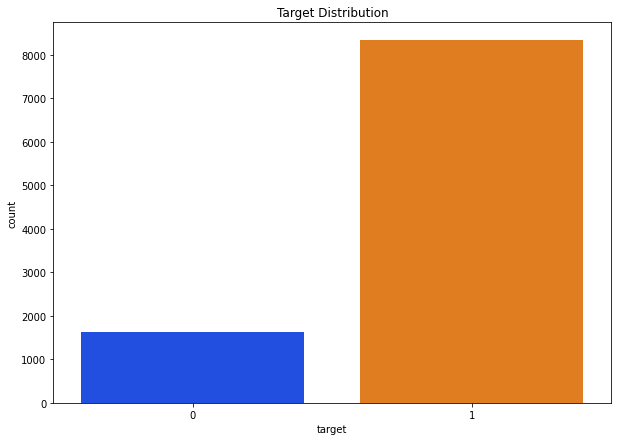

1    83.158630
0    16.242388
Name: target, dtype: float64

In [13]:
plt.figure(figsize=(10, 7))
plt.title("Target Distribution")
sns.countplot(df.target, palette="bright")
plt.show()

100*df.target.value_counts()/len(target)

## PCA Visualization
The PCA shows that the data is quite noisy, thus the best option is to use a robust linear model to fit it properly, even though it has no clusters that can be spoted visually.

In [15]:
X = df.drop("target", axis=1).values
y = df.target.values

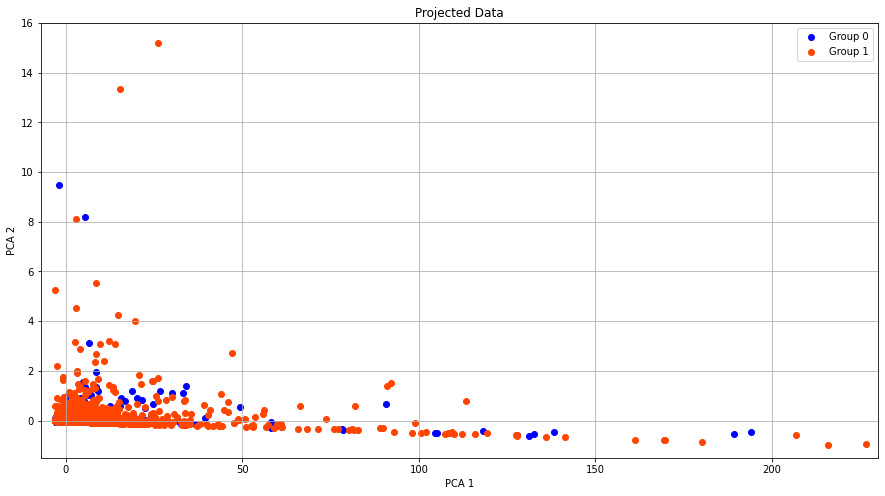

In [22]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform((X-X.mean())/X.std())

n_clusters = y[y==0].shape[0]
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(X_pca[y==1])

X_plot = np.vstack([X_pca[y==0], k_means.cluster_centers_])

xmin, xmax = -7, 230
ymin, ymax = -1.5, 16

plt.figure(figsize=(15, 8))
plt.title("Projected Data")
plt.scatter(X_plot[:n_clusters, 0], X_plot[:n_clusters, 1], color="blue", label="Group 0")
plt.scatter(X_plot[n_clusters:, 0], X_plot[n_clusters:, 1], color="orangered", label="Group 1")
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))
plt.grid()

# Meta Learning Training

To make the predictions we applied a stratified k fold cross validation due to the class unbalanced, the meta learner chosen was a random forecast with its hyperparameters restricted to avoid overfitting and to force the modelling of the minority class as well

In [23]:
y_pred, y_true = np.zeros(y.shape[0]), np.zeros(y.shape[0])
coefs = []
for train_idxs, test_idxs in StratifiedKFold(n_splits=10).split(X, y):
    X_train, y_train = X[train_idxs,:], y[train_idxs]
    X_test, y_test = X[test_idxs,:], y[test_idxs]
    
    model = RandomForestClassifier(max_depth=5, class_weight="balanced", min_samples_split=5, max_samples=0.25)
    model.fit(X_train, y_train)
    
    coefs.append(model.feature_importances_)
    
    y_pred[test_idxs] = model.predict(X_test)
    y_true[test_idxs] = y_test

# Classification Metrics Evaluation

The overall balanced accuracy was 55.96% and as we can see in the confusion matrix the model had a hard time trying to tell apart the classes, specially when the true label is the machine learning group.

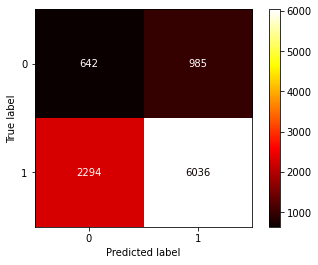

Balanced Accuracy Score: 55.96 %


In [24]:
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap="hot")
plt.show()

print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred)*100:.2f} %")

# Feature Importances

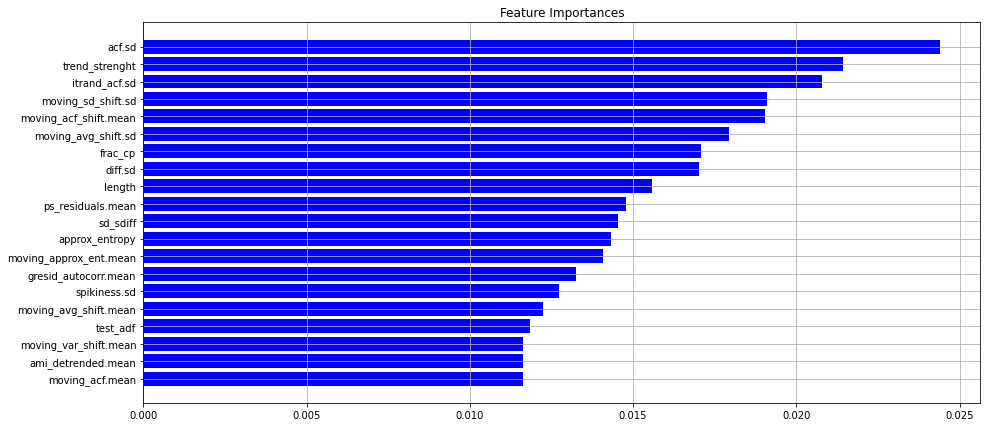

In [25]:
lr_coef = {
    "name":df.drop("target", axis=1).columns, 
    "score": np.array(coefs).mean(axis=0)
}
lr_coef = pd.DataFrame(lr_coef)
lr_coef["score"] = lr_coef["score"].abs()
lr_coef = lr_coef.sort_values(by="score", ascending=False)
to_plot = lr_coef[:20][::-1]
plt.figure(figsize=(15, 7))
plt.title("Feature Importances")
plt.barh(to_plot.name, to_plot.score, color="b")
plt.grid()

## Meta Learning Evaluation

The analysis of the mean over all time series for the 3 metrics considered in the M4 shows that the meta learner was not able to outperform the statistical group, in other words, applying the average model from the statistical group is better than being stick with the meta learning prediction.

In [26]:
trotta = trotta[mask].drop(rows_to_drop, axis=0)
alves = alves[mask].drop(rows_to_drop, axis=0)
muk = muk[mask].drop(rows_to_drop, axis=0)
rnn = rnn[mask].drop(rows_to_drop, axis=0)
pelka = pelka[mask].drop(rows_to_drop, axis=0)
mlp = mlp[mask].drop(rows_to_drop, axis=0)
theta = theta[mask].drop(rows_to_drop, axis=0)
arima = arima[mask].drop(rows_to_drop, axis=0)
damped = damped[mask].drop(rows_to_drop, axis=0)
ets = ets[mask].drop(rows_to_drop, axis=0)
holt = holt[mask].drop(rows_to_drop, axis=0)
ses = ses[mask].drop(rows_to_drop, axis=0)

In [27]:
mean = lambda x: np.apply_along_axis(np.mean, 1, x)
group0 = {
    "SMAPE":mean(np.array([trotta["SMAPE"], alves["SMAPE"], muk["SMAPE"], rnn["SMAPE"], pelka["SMAPE"], mlp["SMAPE"]]).T), 
    "MASE":mean(np.array([trotta["MASE"], alves["MASE"], muk["MASE"], rnn["MASE"], pelka["MASE"], mlp["MASE"]]).T), 
    "OWA":mean(np.array([trotta["OWA"], alves["OWA"], muk["OWA"], rnn["OWA"], pelka["OWA"], mlp["OWA"]]).T)
}
group1 = {
    "SMAPE":mean(np.array([theta["SMAPE"], arima["SMAPE"], damped["SMAPE"], ets["SMAPE"], holt["SMAPE"], ses["SMAPE"]]).T), 
    "MASE":mean(np.array([theta["MASE"], arima["MASE"], damped["MASE"], ets["MASE"], holt["MASE"], ses["MASE"]]).T), 
    "OWA":mean(np.array([theta["OWA"], arima["OWA"], damped["OWA"], ets["OWA"], holt["OWA"], ses["OWA"]]).T)
}


In [28]:
def meta_learner_metrics(group0:dict, group1:dict, predictions:np.ndarray)->dict:
    meta_learner = {"SMAPE":[], "MASE":[], "OWA":[]}
    for i, y in enumerate(predictions):
        if y==0:
            meta_learner["SMAPE"].append(group0["SMAPE"][i])
            meta_learner["MASE"].append(group0["MASE"][i])
            meta_learner["OWA"].append(group0["OWA"][i])
        else:
            meta_learner["SMAPE"].append(group1["SMAPE"][i])
            meta_learner["MASE"].append(group1["MASE"][i])
            meta_learner["OWA"].append(group1["OWA"][i])
        
    meta_learner["SMAPE"] = np.array(meta_learner["SMAPE"])
    meta_learner["MASE"] = np.array(meta_learner["MASE"])
    meta_learner["OWA"] = np.array(meta_learner["OWA"])
    return meta_learner

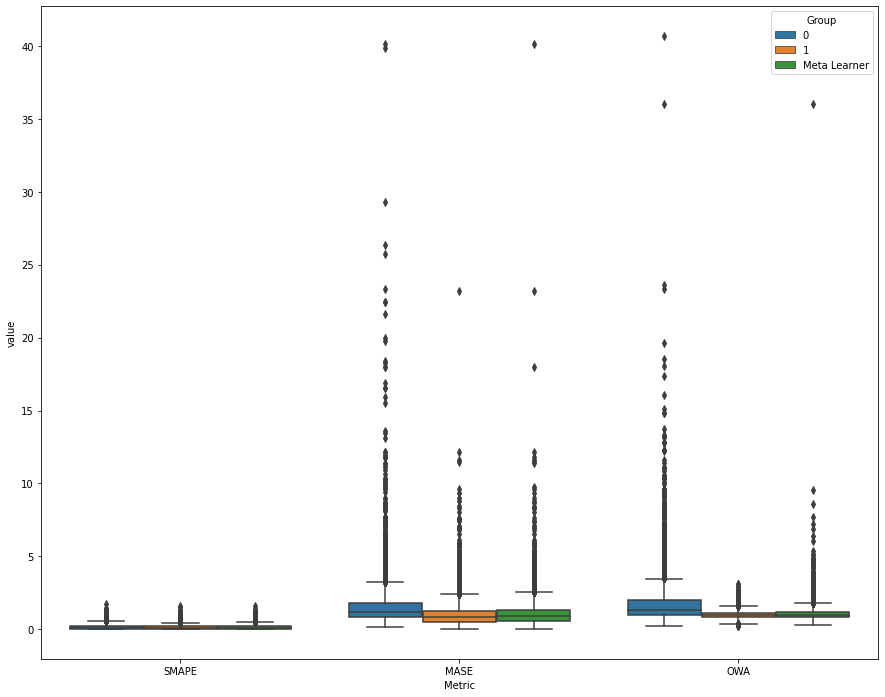

----Mean over all time series----


,SMAPE,MASE,OWA
Group 0,0.178382,1.502414,1.734778
Group 1,0.138627,1.018020,1.000717
Meta Learner,0.149263,1.084482,1.082664


In [29]:
meta_learner = meta_learner_metrics(group0, group1, y_pred)

group = {
    "Metric":["SMAPE"]*y.shape[0] + ["MASE"]*y.shape[0] + ["OWA"]*y.shape[0],
    "0":np.hstack([group0["SMAPE"], group0["MASE"], group0["OWA"]]),
    "1":np.hstack([group1["SMAPE"], group1["MASE"], group1["OWA"]]),
    "Meta Learner":np.hstack([meta_learner["SMAPE"], meta_learner["MASE"], meta_learner["OWA"]])
}

group = pd.DataFrame(group)
group = pd.melt(group, id_vars=['Metric'], value_vars=['0', '1', "Meta Learner"], var_name='Group')
plt.figure(figsize=(15, 12))
sns.boxplot(x='Metric', y='value', data=group, hue='Group')
plt.show()

table = {
    "Group 0": [np.nanmean(group0["SMAPE"]),  np.nanmean(group0["MASE"]),  np.nanmean(group0["OWA"])],
    "Group 1": [np.nanmean(group1["SMAPE"]),  np.nanmean(group1["MASE"]),  np.nanmean(group1["OWA"])],
    "Meta Learner": [np.nanmean(meta_learner["SMAPE"]),  np.nanmean(meta_learner["MASE"]),  np.nanmean(meta_learner["OWA"])],
}
table = pd.DataFrame(table)
table.index = ["SMAPE", "MASE", "OWA"]
print("----Mean over all time series----")
table.T

# Statistical Difference Between the Groups

Using the Kolmogorov-Smirnov test on 2 samples we can conclude that:

- SMAPE : We can reject the null hypotesis (2 independent samples are drawn from the same continuous distribution) for all comparisons.
- MASE : Same as SMAPE
- OWA : Same as SMAPE

In [30]:
def plot_dist(metric):
    plt.figure(figsize=(10, 7))
    plt.title(f"{metric} distribution")
    sns.distplot(power_transform(group0[metric].reshape(-1, 1)), label="Group 0", hist=False)
    sns.distplot(power_transform(group1[metric].reshape(-1, 1)), label="Group 1", hist=False)
    sns.distplot(power_transform(meta_learner[metric].reshape(-1, 1)), label="Meta Learner", hist=False)
    plt.legend()
    plt.grid()
    plt.show()
    
def stats_test(metric):
    print(f"Group 0 x Meta Learner: \t{ks_2samp(group0[metric], meta_learner[metric])}")
    print(f"Group 1 x Meta Learner: \t{ks_2samp(group1[metric], meta_learner[metric])}")
    print(f"Group 0 x Group 1: \t\t{ks_2samp(group0[metric], group1[metric])}")

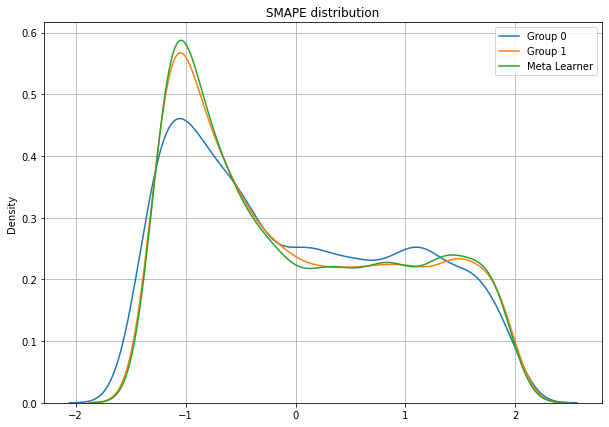

Group 0 x Meta Learner: 	KstestResult(statistic=0.1451240333433765, pvalue=8.125618353126268e-92)
Group 1 x Meta Learner: 	KstestResult(statistic=0.024907100532288843, pvalue=0.004152094756378227)
Group 0 x Group 1: 		KstestResult(statistic=0.14974389876468816, pvalue=9.46591908914479e-98)


In [31]:
plot_dist("SMAPE")
stats_test("SMAPE")

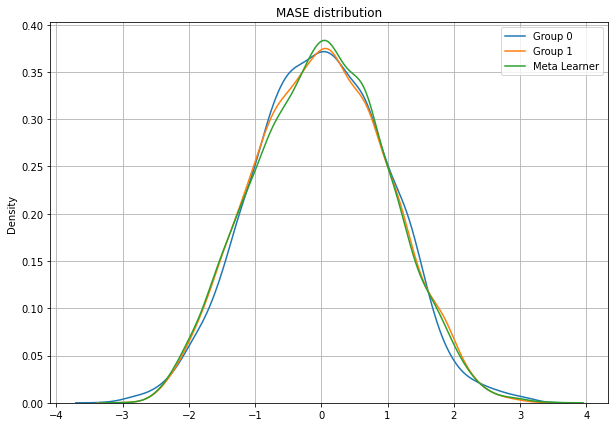

Group 0 x Meta Learner: 	KstestResult(statistic=0.21181078638144019, pvalue=6.768137544613512e-196)
Group 1 x Meta Learner: 	KstestResult(statistic=0.04449131264437079, pvalue=5.480764406522055e-09)
Group 0 x Group 1: 		KstestResult(statistic=0.2548960530280205, pvalue=1.717218687445887e-284)


In [32]:
plot_dist("MASE")
stats_test("MASE")

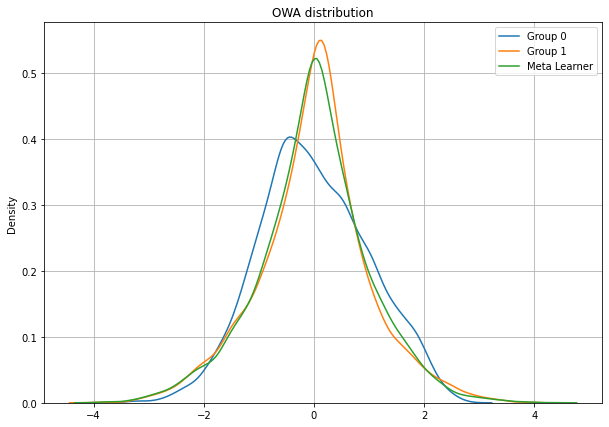

Group 0 x Meta Learner: 	KstestResult(statistic=0.32841217234106657, pvalue=1e-323)
Group 1 x Meta Learner: 	KstestResult(statistic=0.08215325901375917, pvalue=1.214506703291344e-29)
Group 0 x Group 1: 		KstestResult(statistic=0.4022295872250678, pvalue=0.0)


In [33]:
plot_dist("OWA")
stats_test("OWA")